# Finding other approaches for regression
Compare how our current method of using 4th order polynomials compares to 
- using piece-wise splines, or 
- least squares fitting to B-splines, or 
- trying different penalization methods to choose a "good enough" polynomial order (or, equivalently, number of basis functions). 

These other methods like using interpolating splines can have some advantages over using polynomial basis functions, such as 
- they might result in a smoother trajectory and 
- the derivatives at the end points won't be as high or 
- subject to the Runge phenomenon.

We can determine the order/ number of basis functions to use at run time; we could do this (relatively simply) by having a threshold on the tradeoff between the sum of residuals and the order of the polynomials. If that is the case, we wouldn't need to consider other splines or methods, and would run code that fits data from the current GuSTO solution to increasing orders of polynomials and returns the order that works well enough. There's definitely some amount of theoretical exploration to be done here.

In [1]:
using Polynomials
using LinearAlgebra
using JLD2, FileIO
using Plots
using Interpolations
include("astrobee_se3_script.jl")


┌ Info: Recompiling stale cache file /home/somrita/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


plot_square (generic function with 1 method)

# Helper functions

In [2]:
function plot_env_and_trajs_clean(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    
    idx = [1,2]
    p1 = plot()
    cls = [1, 3]
    cls = [1, 4]
#     local fig
#     fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        cl = cls[iter]
        plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = cl)
        scatter!((X[idx[1],1], X[idx[2],1]), marker=5, lab="", color=7)
        scatter!((X[idx[1],end], X[idx[2],end]), marker=5, lab="", color=9)
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        buf = 0.2
        r1 = r1-buf
        r2 = r2-buf
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg = true)
    xlabel!("x")
    # ylabel!("y")
    annotate!([(-1,5,Plots.text("y",16))])
    plot!(legendfontsize = 16, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:topright,yrotation = 0)
    plot!(gridalpha = 0.2)
    scatter!((x_init_recov[1],x_init_recov[2]), marker=10, lab="", color=7)
    scatter!((x_final_recov[1],x_final_recov[2]), marker=10, lab="", color = 9)
    annotate!([(x_init_recov[1],x_init_recov[2]+0.8,Plots.text("\$x_{init}\$", 18, :black, :center))])
    annotate!([(x_final_recov[1],x_final_recov[2]-0.8,Plots.text("\$x_{final}\$", 18, :black, :center))])
    return p1
#     return fig
end

plot_env_and_trajs_clean (generic function with 2 methods)

In [3]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 2.0
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

In [4]:
function getComponentsFromData(train_input, train_output)
    N = 50 
    x_dim = 13
    u_dim = 6
    x_init = train_input[1:x_dim]
    x_final = train_input[x_dim+1:end]
    X_row = train_output[1:x_dim*N]
    X_soln = reshape(X_row, (x_dim,N))
    U_row = train_output[(1+x_dim*N) : end]
    U_soln = reshape(U_row, (u_dim,N-1))
    return x_init, x_final, X_soln, U_soln
end

getComponentsFromData (generic function with 1 method)

In [5]:
function plotCoeffs(coeffs)
    gr(fmt=:png)
    plot()
    plot!(coeffs,
        xlabel = "#",
        ylabel = "coeff",
        legend = :none)
    plot!()
end

plotCoeffs (generic function with 1 method)

In [6]:
function fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
    x_dim = 13
    u_dim = 6
    fit_coeffs = zeros((x_dim+u_dim), num_coeffs)

    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]

    # Get fitted polynomial coefficients
    for dim = 1:x_dim
        x_vals = X_soln_recov[dim, :]
        p = polyfit(t_array, x_vals, num_coeffs-1, :t)
        cf = coeffs(p)
        if (size(cf,1) == 1 && cf[1] == 0)
            cf = zeros(num_coeffs)
        end
        fit_coeffs[dim,:] = cf
    end
    for dim = 1:u_dim
        u_vals = U_soln_recov[dim, :]
        p = polyfit(t_minus_one_array, u_vals, num_coeffs-1, :t)
        cf = coeffs(p)
        if (size(cf,1) == 1 && cf[1] == 0)
            cf = zeros(num_coeffs)
        end
        fit_coeffs[x_dim + dim,:] = cf
    end
    cf_x = fit_coeffs[1,:]
    cf_y = fit_coeffs[2,:]
    x_poly = polyval(Poly(cf_x), t_array)
    y_poly = polyval(Poly(cf_y), t_array)
    xy_poly = vcat([x_poly', y_poly']...)
    return fit_coeffs, xy_poly
end

fitToPoly (generic function with 1 method)

## Step 1:
- Take some GuSTO data
- Fit to 4th order poly
- Fit to 5th order poly
- Calculate residuals in both cases

In [7]:
# Take some GuSTO data and Pick one trajectory
@load "PolyMore.jld2" train_input_collected train_output_collected
@show size(train_input_collected)
@show size(train_output_collected)

row = 836

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)

size(train_input_collected) = (5930, 26)
size(train_output_collected) = (5930, 944)


([0.9375, 6.125, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [8.0, 2.1875, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.9375 0.948121 … 7.96988 7.99901; 6.125 6.12532 … 2.18027 2.18652; … ; 0.0 3.82986e-6 … 1.49724e-6 4.13289e-9; 0.0 -1.06999e-6 … 6.01459e-6 1.20726e-8], [0.0206821 0.0400126 … -0.0485126 -0.0384137; 0.000789724 0.00105186 … -0.00138669 -0.00575577; … ; 1.25617e-7 2.43908e-7 … -9.59298e-8 -7.20314e-8; -3.52985e-8 -6.79398e-8 … -3.87572e-7 -2.89578e-7])

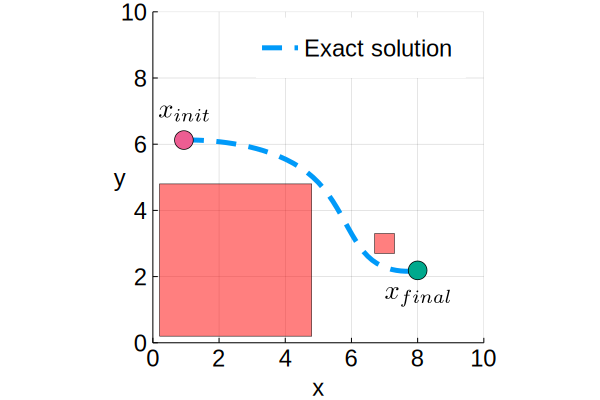

In [8]:
# Plot this one trajectory
model = getModelWithTwoPolyObsOneAtCorner()
plot_env_and_trajs_clean(model, [X_soln_recov],["Exact solution"])


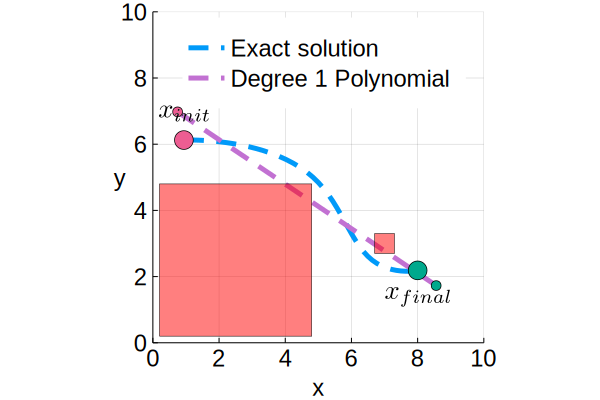

In [9]:
# Fit to 1st order poly
num_coeffs = 2
fit_coeffs, xy_poly_1 = fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
plot_env_and_trajs_clean(model, [X_soln_recov, xy_poly_1],["Exact solution","Degree 1 Polynomial"])

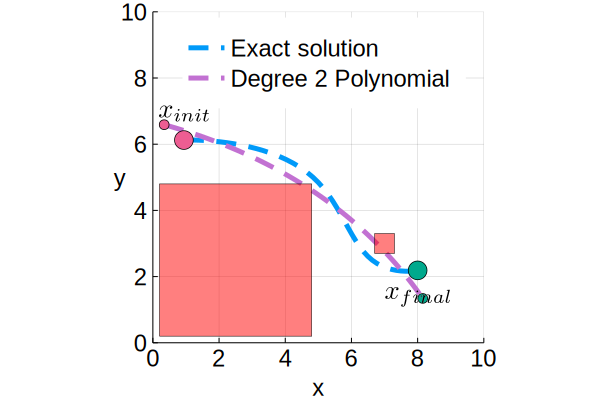

In [10]:
# Fit to 2nd order poly
num_coeffs = 3
fit_coeffs, xy_poly_2 = fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
plot_env_and_trajs_clean(model, [X_soln_recov, xy_poly_2],["Exact solution","Degree 2 Polynomial"])

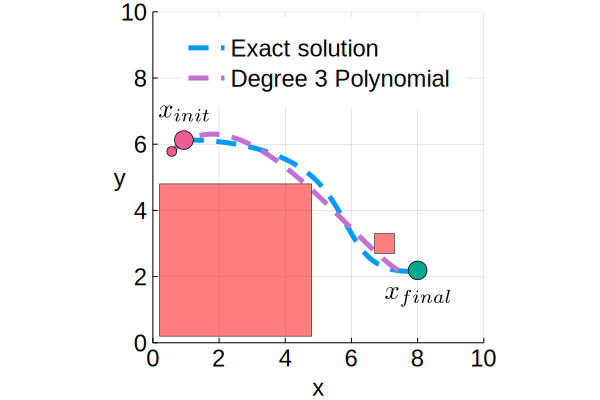

In [11]:
# Fit to 3rd order poly
num_coeffs = 4
fit_coeffs, xy_poly_3 = fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
plot_env_and_trajs_clean(model, [X_soln_recov, xy_poly_3],["Exact solution","Degree 3 Polynomial"])

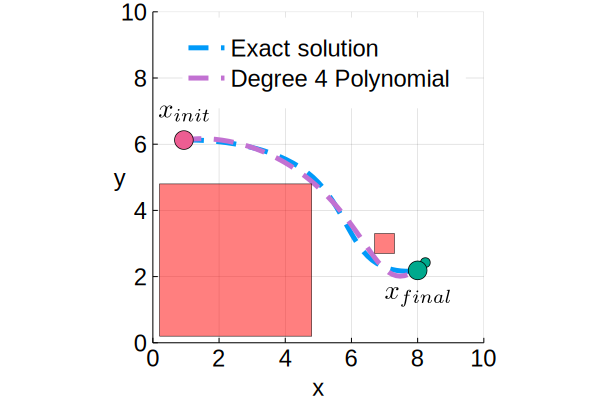

In [12]:
# Fit to 4th order poly
num_coeffs = 5
fit_coeffs, xy_poly_4 = fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
plot_env_and_trajs_clean(model, [X_soln_recov, xy_poly_4],["Exact solution","Degree 4 Polynomial"])

## Step 2:
- Generate plot of order vs. residual amount
- Generate plot of trajectory- original vs. 2 poly vs. 3 poly vs. 4 poly, etc.

In [13]:
# Calculate error = sum of squares of residuals
function sumSqResiduals(X_truth, X_est)
    xy_truth = X_truth[1:2,:]
    xy_est = X_est[1:2,:]
    sq_resid = ((xy_est - xy_truth).^2)
    error = sum(sq_resid)
    return error
end

sumSqResiduals (generic function with 1 method)

In [14]:
sumSqResiduals(X_soln_recov, xy_poly_1)

12.036301278779238

In [15]:
sumSqResiduals(X_soln_recov, xy_poly_2)

8.480689533313244

In [16]:
sumSqResiduals(X_soln_recov, xy_poly_3)

2.0618002174376535

In [17]:
sumSqResiduals(X_soln_recov, xy_poly_4)

0.6453366460635673

In [18]:
errorVals = zeros(10)
for order=1:10
    # Fit to nth order poly
    num_coeffs = order+1
    fit_coeffs, xy_poly = fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
    errorVals[order] = sumSqResiduals(X_soln_recov, xy_poly)
end

In [19]:
@show errorVals

errorVals = [12.0363, 8.48069, 2.0618, 0.645337, 0.222222, 0.0177378, 0.0165926, 111.061, 326.008, 418.921]


10-element Array{Float64,1}:
  12.036301278779238   
   8.480689533313244   
   2.0618002174376535  
   0.6453366460635673  
   0.22222240562394152 
   0.01773782287165825 
   0.016592643694111394
 111.06125543991472    
 326.00813114367395    
 418.92095667149584    

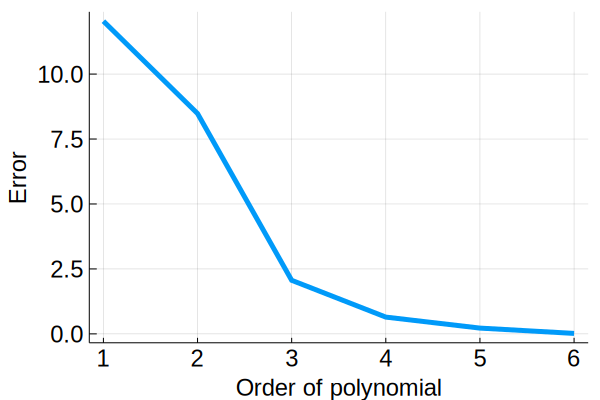

In [20]:
plot(1:6,errorVals[1:6]; line=(5), lab = "")
xticks!(1:6)
xlabel!("Order of polynomial")
ylabel!("Error")
plot!(tickfontsize = 16, guidefontsize = 16,yrotation = 0)
plot!(gridalpha = 0.2)

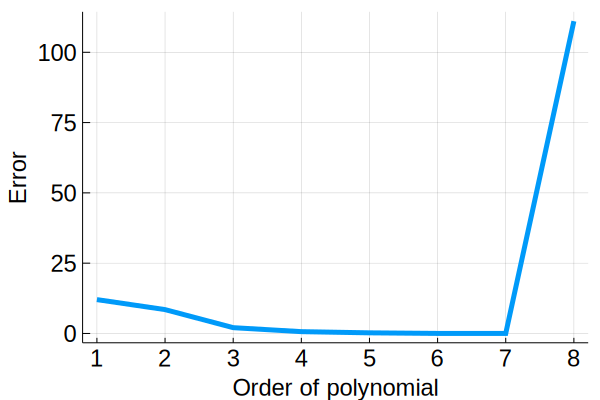

In [21]:
plot(1:8,errorVals[1:8]; line=(5), lab = "")
xticks!(1:8)
xlabel!("Order of polynomial")
ylabel!("Error")
plot!(tickfontsize = 16, guidefontsize = 16,yrotation = 0)
plot!(gridalpha = 0.2)

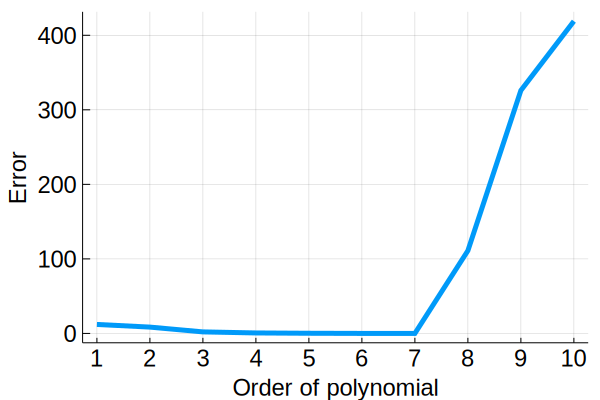

In [22]:
plot(1:10,errorVals; line=(5), lab = "")
xticks!(1:10)
xlabel!("Order of polynomial")
ylabel!("Error")
plot!(tickfontsize = 16, guidefontsize = 16,yrotation = 0)
plot!(gridalpha = 0.2)

In [23]:
# Interesting. Why does this skyrocket?

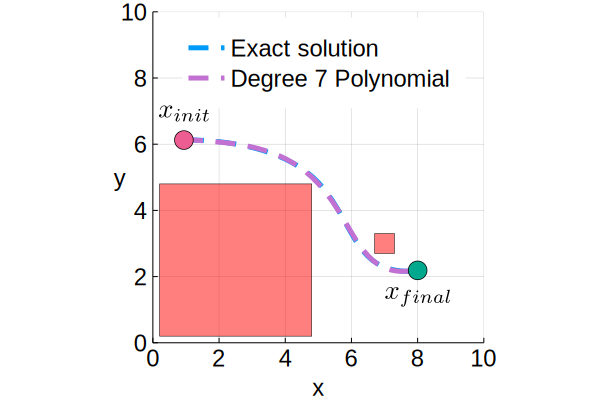

In [24]:
# Fit to 7th order poly
num_coeffs = 8
fit_coeffs, xy_poly_7 = fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
plot_env_and_trajs_clean(model, [X_soln_recov, xy_poly_7],["Exact solution","Degree 7 Polynomial"])

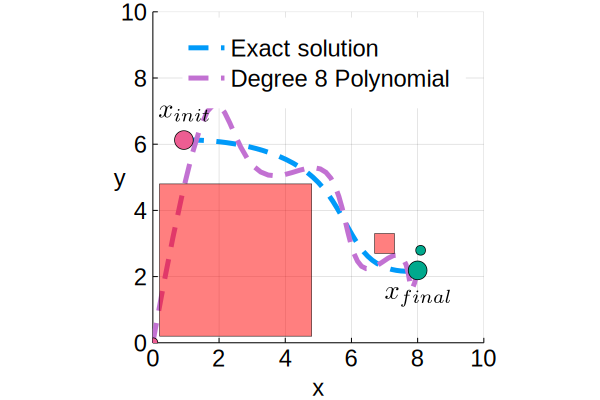

In [25]:
# Fit to 8th order poly
num_coeffs = 9
fit_coeffs, xy_poly_8 = fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
plot_env_and_trajs_clean(model, [X_soln_recov, xy_poly_8],["Exact solution","Degree 8 Polynomial"])

# To pick colors

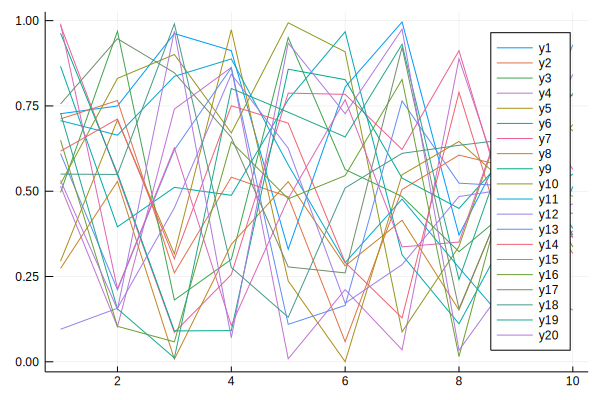

In [26]:
x = rand(10,20)
plot(x)

# Plot to illustrate bias-variance tradeoff

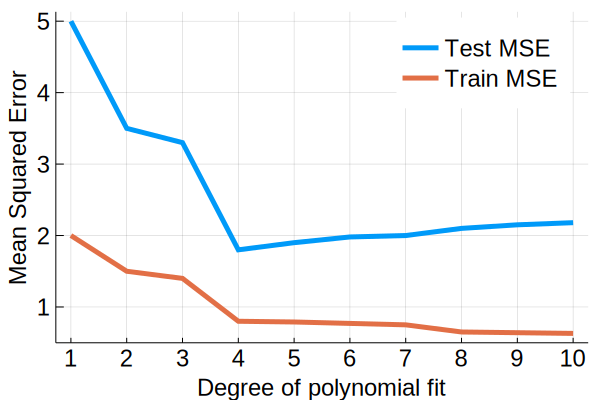

In [27]:
xs = 1:10
test_mse = [5, 3.5, 3.3, 1.8, 1.9, 1.98, 2.0, 2.1, 2.15, 2.18]
train_mse = [ 2.0, 1.5, 1.4, 0.8, 0.79, 0.77, 0.75, 0.65, 0.64, 0.63]
plot(xs,test_mse, lab = "Test MSE", line = 5)
plot!(xs,train_mse, lab = "Train MSE", line = 5)
xticks!(1:10)
plot!(leg = true)
xlabel!("Degree of polynomial fit")
ylabel!("Mean Squared Error")
plot!(legendfontsize = 16, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:topright,yrotation = 0)
plot!(gridalpha = 0.2)

## Step 3:
- Pick a cost function that trades off order and residual
- Do a bisection search to find the optimal order

$$J = \frac{\Sigma (x_{est}-x_{true})^2}{n - 1 -m}$$

J = [0.15, 0.12, 0.11, 0.09, 0.085, 0.093, 0.1]


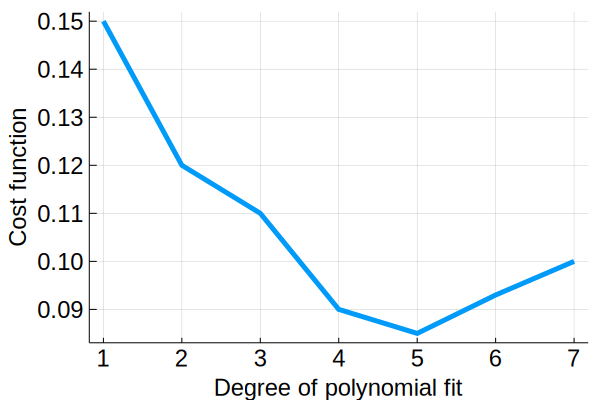

In [28]:
# Made up graph for cost function

# n = 10
# J = zeros(7)
# for order = 1:7
#     num_coeffs = order+1
#     fit_coeffs, xy_poly = fitToPoly(num_coeffs, X_soln_recov, U_soln_recov)
#     ssr = sumSqResiduals(X_soln_recov, xy_poly)
#     J[order] = ssr/(n-1-num_coeffs)
# end
J = [0.15, 0.12, 0.11, 0.09, 0.085, 0.093, 0.10]
@show J
plot(1:7, J[1:7], line = 5, lab="")
# xlims!((1,7))
xticks!(1:7)
plot!(leg = true)
xlabel!("Degree of polynomial fit")
ylabel!("Cost function")
plot!(legendfontsize = 16, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:topright,yrotation = 0)
plot!(gridalpha = 0.2)


## Step 4:
- What are some other cost functions? (3 total cost functions max)
- How does the behavior change?

# Using cubic splines

## Demo of functionality

In [33]:
f(x,y) = log(x+y)
xs = 1:0.2:5
ys = 2:0.1:5
A = [f(x,y) for x in xs, y in ys]

# linear interpolation
interp_linear = LinearInterpolation((xs, ys), A)
@show interp_linear(3, 2) # exactly log(3 + 2)
@show log(3+2)
@show interp_linear(3.1, 2.1) # approximately log(3.1 + 2.1)
@show log(3.1+2.1)

# cubic spline interpolation
interp_cubic = CubicSplineInterpolation((xs, ys), A)
@show interp_cubic(3, 2) # exactly log(3 + 2)
@show log(3+2)
@show interp_cubic(3.1, 2.1) # approximately log(3.1 + 2.1)
@show log(3.1+2.1)

interp_linear(3, 2) = 1.6094379124341003
log(3 + 2) = 1.6094379124341003
interp_linear(3.1, 2.1) = 1.6484736801441782
log(3.1 + 2.1) = 1.6486586255873816
interp_cubic(3, 2) = 1.6094379124341
log(3 + 2) = 1.6094379124341003
interp_cubic(3.1, 2.1) = 1.6486586594237707
log(3.1 + 2.1) = 1.6486586255873816


1.6486586255873816

## Pick the trajectory

In [106]:
# Take some GuSTO data and Pick one trajectory
@load "PolyMore.jld2" train_input_collected train_output_collected
@show size(train_input_collected)
@show size(train_output_collected)

row = 836

train_input = train_input_collected[row, :]
train_output = train_output_collected[row, :]
x_init_recov, x_final_recov, X_soln_recov, U_soln_recov = getComponentsFromData(train_input, train_output)
N = 50
tf_guess = 110.
t_array = range(0,stop=tf_guess,length=N)
t_minus_one_array = t_array[1:end-1]

ts = t_array
@show size(ts)
xs = X_soln_recov[1,:]
ys = X_soln_recov[2,:]
@show size(xs)
@show size(ys)
@show typeof(xs)

size(train_input_collected) = (5930, 26)
size(train_output_collected) = (5930, 944)
size(ts) = (50,)
size(xs) = (50,)
size(ys) = (50,)
typeof(xs) = Array{Float64,1}


Array{Float64,1}

## Cubic spline interpolation with all 50 points

In [112]:
# Perfect interpolation with all 50 points
# cubic spline interpolation
interp_cubic_x = CubicSplineInterpolation(ts, xs)
interp_cubic_y = CubicSplineInterpolation(ts, ys)
@show interp_cubic_x(0.0) # exactly start point
@show xs[1]
@show interp_cubic_x(110.0) # exactly end point
@show xs[end]
@show interp_cubic_x(45.0)
@show ts[21]
@show ts[22]
@show xs[21]
@show xs[22]

interp_cubic_x(0.0) = 0.9374999999999999
xs[1] = 0.9375
interp_cubic_x(110.0) = 7.99901034358799
xs[end] = 7.99901034358799
interp_cubic_x(45.0) = 4.2508038016890515
ts[21] = 44.89795918367347
ts[22] = 47.142857142857146
xs[21] = 4.241187736588799
xs[22] = 4.44863882560734


4.44863882560734

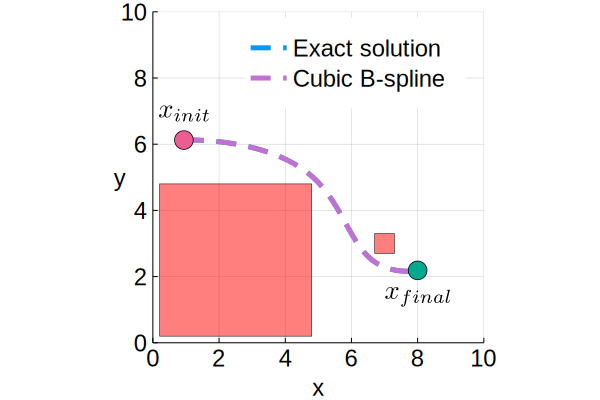

In [113]:
xy_interp = zeros(2,50)
for i in 1:50
    t = ts[i]
    xy_interp[1,i] = interp_cubic_x(t)
    xy_interp[2,i] = interp_cubic_y(t)
end
plot_env_and_trajs_clean(model, [X_soln_recov, xy_interp],["Exact solution","Cubic B-spline"])

## Linear spline interpolation on some of the points

In [114]:
# Linear spline interpolation on some of the points
idxs = [1, 10, 20, 30, 40, 50] # should include 1 and 50 always
ts_small = [ts[i] for i in idxs]
@show ts_small
@show size(ts_small)
xs_small = [xs[i] for i in idxs]
@show size(xs_small)
ys_small = [ys[i] for i in idxs]
@show size(ys_small)
# linear gridded spline interpolation
interp_linear_x = extrapolate(interpolate((ts_small,), xs_small, Gridded(Linear())), Flat())
interp_linear_y = extrapolate(interpolate((ts_small,), ys_small, Gridded(Linear())), Flat())

@show interp_linear_x(0.0) # exactly start point
@show xs[1]
@show interp_linear_x(110) # exactly end point
@show xs[end]

ts_small = [0.0, 20.2041, 42.6531, 65.102, 87.551, 110.0]
size(ts_small) = (6,)
size(xs_small) = (6,)
size(ys_small) = (6,)
interp_linear_x(0.0) = 0.9375
xs[1] = 0.9375
interp_linear_x(110) = 7.99901034358799
xs[end] = 7.99901034358799


7.99901034358799

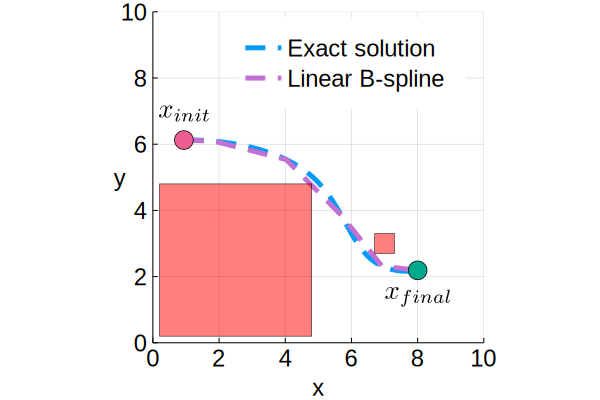

In [115]:
xy_interp = zeros(2,50)
for i in 1:50
    t = ts[i]
    xy_interp[1,i] = interp_linear_x(t)
    xy_interp[2,i] = interp_linear_y(t)
end
plot_env_and_trajs_clean(model, [X_soln_recov, xy_interp],["Exact solution","Linear B-spline"])

## Cubic spline interpolation on some of the points

In [190]:
# Factor of 2
@show ts
factor = 2
dt = step(ts)
len = length(ts)
len_new = Int32(len/factor)
@show len_new
ts_new = range(ts[1], step = factor*dt, stop = ts[end])
@show ts_new

xs_new = zeros(len_new)
ys_new = zeros(len_new)
for i = 1:len_new
    ind = 1+ factor*(i-1)
    xs_new[i] = xs[ind]
    ys_new[i] = ys[ind]
end
@show xs_new
@show ys_new
interp_cubic_x = CubicSplineInterpolation(ts_new, xs_new)
interp_cubic_y = CubicSplineInterpolation(ts_new, ys_new)
@show interp_cubic_x(0)
@show interp_cubic_x(100)

ts = 0.0:2.2448979591836733:110.0
len_new = 25
ts_new = 0.0:4.489795918367347:107.75510204081633
xs_new = [0.9375, 0.982892, 1.12889, 1.3642, 1.67371, 2.04227, 2.45475, 2.89601, 3.35093, 3.80437, 4.24119, 4.64626, 5.0047, 5.30865, 5.5678, 5.79887, 6.01884, 6.24466, 6.49301, 6.77186, 7.06753, 7.35766, 7.61958, 7.83062, 7.96988]
ys_new = [6.125, 6.12615, 6.12706, 6.12205, 6.10522, 6.07066, 6.01247, 5.92473, 5.80155, 5.63702, 5.42524, 5.16031, 4.83808, 4.46659, 4.06613, 3.65869, 3.26629, 2.91093, 2.61463, 2.3969, 2.25972, 2.18757, 2.16243, 2.16626, 2.18027]
interp_cubic_x(0) = 0.9375
interp_cubic_x(100) = 7.6837532276146625


7.6837532276146625

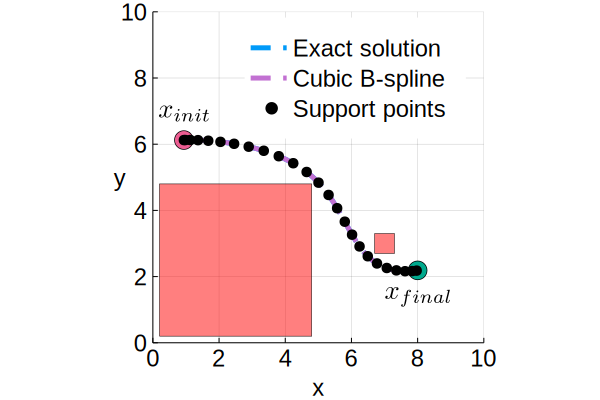

In [191]:
xy_interp = zeros(2,49)
for i in 1:49
    t = ts[i]
    xy_interp[1,i] = interp_cubic_x(t)
    xy_interp[2,i] = interp_cubic_y(t)
end
plot_env_and_trajs_clean(model, [X_soln_recov, xy_interp],["Exact solution","Cubic B-spline"])
scatter!(xs_new, ys_new, lab = "Support points", color = :black, markersize = 5)

In [198]:
# Factor of 5
@show ts
factor = 5
dt = step(ts)
len = length(ts)
len_new = Int32(len/factor)
@show len_new
ts_new = range(ts[1], step = factor*dt, stop = ts[end])
@show ts_new

xs_new = zeros(len_new)
ys_new = zeros(len_new)
for i = 1:len_new
    ind = 1+ factor*(i-1)
    xs_new[i] = xs[ind]
    ys_new[i] = ys[ind]
end
@show xs_new
@show ys_new
interp_cubic_x = CubicSplineInterpolation(ts_new, xs_new)
interp_cubic_y = CubicSplineInterpolation(ts_new, ys_new)
@show interp_cubic_x(0)
@show interp_cubic_x(100)

ts = 0.0:2.2448979591836733:110.0
len_new = 10
ts_new = 0.0:11.224489795918366:101.0204081632653
xs_new = [0.9375, 1.23633, 2.04227, 3.12271, 4.24119, 5.16324, 5.79887, 6.36507, 7.06753, 7.73288]
ys_new = [6.125, 6.12567, 6.07066, 5.86794, 5.42524, 4.65733, 3.65869, 2.75402, 2.25972, 2.16185]
interp_cubic_x(0) = 0.9374999999999999
interp_cubic_x(100) = 7.67418326215254


7.67418326215254

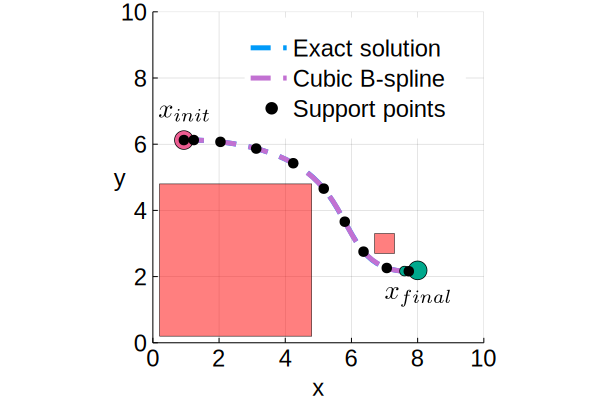

In [199]:
xy_interp = zeros(2,45)
for i in 1:45
    t = ts[i]
    xy_interp[1,i] = interp_cubic_x(t)
    xy_interp[2,i] = interp_cubic_y(t)
end
plot_env_and_trajs_clean(model, [X_soln_recov, xy_interp],["Exact solution","Cubic B-spline"])
scatter!(xs_new, ys_new, lab = "Support points", color = :black, markersize = 5)

In [200]:
# Factor of 10
@show ts
factor = 10
dt = step(ts)
len = length(ts)
len_new = Int32(len/factor)
@show len_new
ts_new = range(ts[1], step = factor*dt, length = len_new + 1)
@show ts_new

xs_new = zeros(len_new+1)
ys_new = zeros(len_new+1)
for i = 1:len_new
    ind = 1+ factor*(i-1)
    xs_new[i] = xs[ind]
    ys_new[i] = ys[ind]
end
xs_new[end] = xs[end]
ys_new[end] = ys[end]
@show xs_new
@show ys_new
interp_cubic_x = CubicSplineInterpolation(ts_new, xs_new)
interp_cubic_y = CubicSplineInterpolation(ts_new, ys_new)
@show interp_cubic_x(0)
@show interp_cubic_x(100)

ts = 0.0:2.2448979591836733:110.0
len_new = 5
ts_new = 0.0:22.448979591836732:112.24489795918366
xs_new = [0.9375, 2.04227, 4.24119, 5.79887, 7.06753, 7.99901]
ys_new = [6.125, 6.07066, 5.42524, 3.65869, 2.25972, 2.18652]
interp_cubic_x(0) = 0.9374999999999999
interp_cubic_x(100) = 7.524309299001123


7.524309299001123

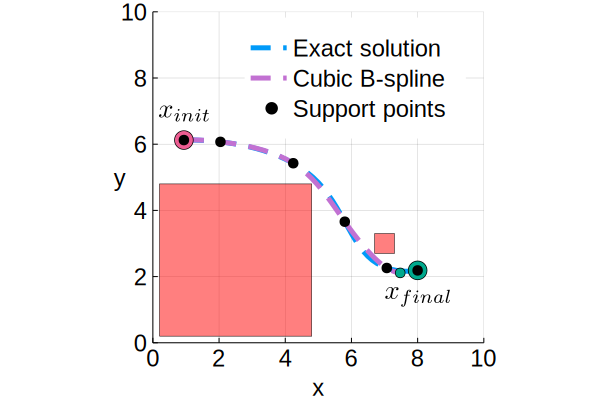

In [201]:
xy_interp = zeros(2,45)
for i in 1:45
    t = ts[i]
    xy_interp[1,i] = interp_cubic_x(t)
    xy_interp[2,i] = interp_cubic_y(t)
end
plot_env_and_trajs_clean(model, [X_soln_recov, xy_interp],["Exact solution","Cubic B-spline"])
scatter!(xs_new, ys_new, lab = "Support points", color = :black, markersize = 5)

In [202]:
# Factor of 25
@show ts
factor = 25
dt = step(ts)
len = length(ts)
len_new = Int32(len/factor)
@show len_new
ts_new = range(ts[1], step = factor*dt, length = len_new + 1)
@show ts_new

xs_new = zeros(len_new+1)
ys_new = zeros(len_new+1)
for i = 1:len_new
    ind = 1+ factor*(i-1)
    xs_new[i] = xs[ind]
    ys_new[i] = ys[ind]
end
xs_new[end] = xs[end]
ys_new[end] = ys[end]
@show xs_new
@show ys_new
interp_cubic_x = CubicSplineInterpolation(ts_new, xs_new)
interp_cubic_y = CubicSplineInterpolation(ts_new, ys_new)
@show interp_cubic_x(0)
@show interp_cubic_x(100)

ts = 0.0:2.2448979591836733:110.0
len_new = 2
ts_new = 0.0:56.12244897959183:112.24489795918366
xs_new = [0.9375, 5.16324, 7.99901]
ys_new = [6.125, 4.65733, 2.18652]
interp_cubic_x(0) = 0.9374999999999998
interp_cubic_x(100) = 7.452505317273944


7.452505317273944

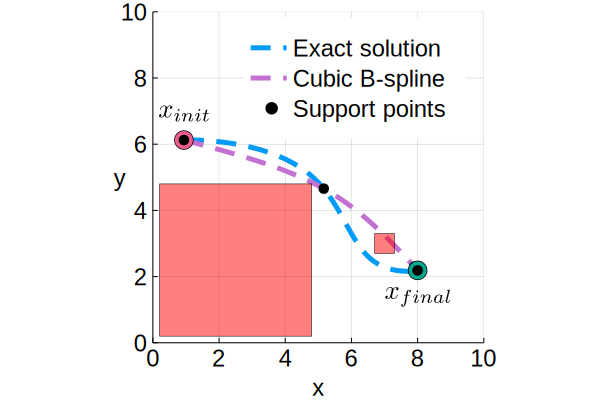

In [203]:
xy_interp = zeros(2,50)
for i in 1:50
    t = ts[i]
    xy_interp[1,i] = interp_cubic_x(t)
    xy_interp[2,i] = interp_cubic_y(t)
end
plot_env_and_trajs_clean(model, [X_soln_recov, xy_interp],["Exact solution","Cubic B-spline"])
scatter!(xs_new, ys_new, lab = "Support points", color = :black, markersize = 5)

In [206]:
# 4 points
@show ts
len_new = 4
dt = step(ts)
len = length(ts)
factor = Int32(ceil(len/len_new))
@show len_new
ts_new = range(ts[1], step = factor*dt, length = len_new + 1)
@show ts_new

xs_new = zeros(len_new+1)
ys_new = zeros(len_new+1)
for i = 1:len_new
    ind = 1+ factor*(i-1)
    xs_new[i] = xs[ind]
    ys_new[i] = ys[ind]
end
xs_new[end] = xs[end]
ys_new[end] = ys[end]
@show xs_new
@show ys_new
interp_cubic_x = CubicSplineInterpolation(ts_new, xs_new)
interp_cubic_y = CubicSplineInterpolation(ts_new, ys_new)
@show interp_cubic_x(0)
@show interp_cubic_x(100)

ts = 0.0:2.2448979591836733:110.0
len_new = 4
ts_new = 0.0:29.183673469387752:116.73469387755101
xs_new = [0.9375, 2.67273, 5.30865, 6.91897, 7.99901]
ys_new = [6.125, 5.97266, 4.46659, 2.31905, 2.18652]
interp_cubic_x(0) = 0.9374999999999999
interp_cubic_x(100) = 7.399970348079353


7.399970348079353

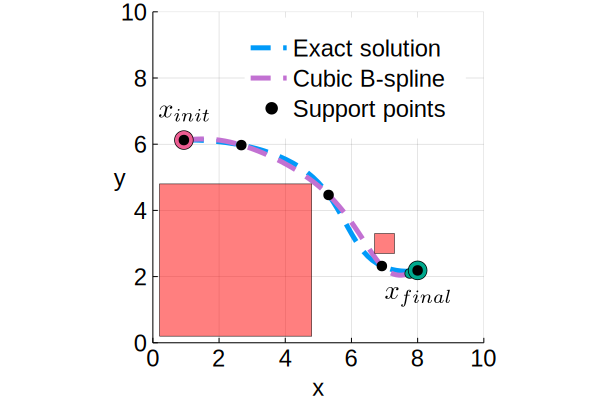

In [207]:
xy_interp = zeros(2,50)
for i in 1:50
    t = ts[i]
    xy_interp[1,i] = interp_cubic_x(t)
    xy_interp[2,i] = interp_cubic_y(t)
end
plot_env_and_trajs_clean(model, [X_soln_recov, xy_interp],["Exact solution","Cubic B-spline"])
scatter!(xs_new, ys_new, lab = "Support points", color = :black, markersize = 5)